In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

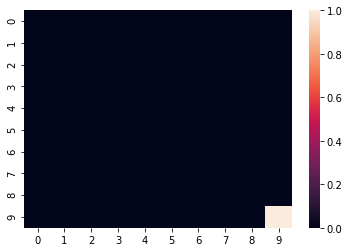

In [3]:
hm1 = sns.heatmap(Rfunc1)

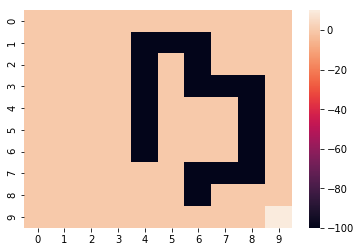

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate
print(width, height)

10 10


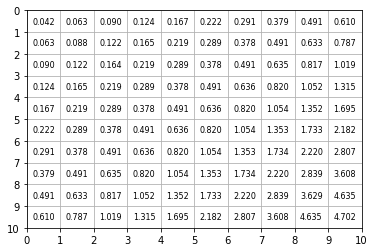

In [12]:
Vs1_2d = Vs1.reshape((height, width))
#print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs1_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

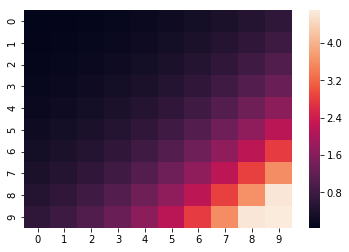

In [13]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    ll = [1, 0, 3, 2]
    return [ll[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

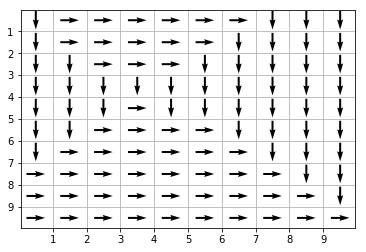

In [16]:
#optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path1 * np.pi / 2)
V = np.sin(path1 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

In [17]:
#problem6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

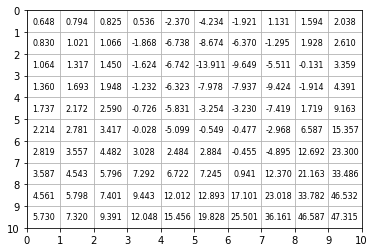

In [18]:
Vs2_2d = Vs2.reshape((height, width))
fig = plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
for j in range(width):
    for i in range(height):
        plt.text(i + 0.5, j + 0.5, '%.3f' %Vs2_2d[i][j], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 8, color='black')
plt.grid()
plt.show()

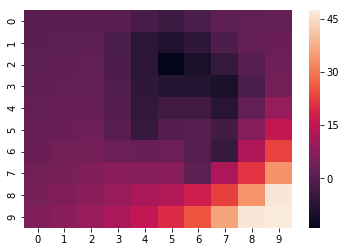

In [19]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [20]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

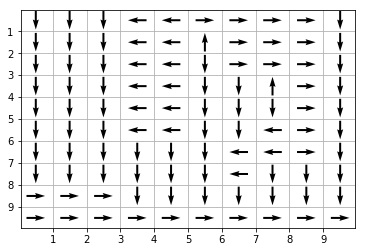

In [21]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
X = np.arange(0.5, height, 1)
Y = np.arange(0.5, width, 1)
U = np.cos(path2 * np.pi / 2)
V = np.sin(path2 * np.pi / 2)
plt.figure()
ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks(np.arange(0, width + 1, 1))
ax.set_yticks(np.arange(0, height + 1, 1))
plt.quiver(X,Y,U,V,units='x',pivot='mid')
plt.grid()
plt.show()

In [22]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [23]:
tpm = tp2tpm(height, width, tp)

In [24]:
#Question 11:
import numpy as np
from cvxopt import solvers
lamda_list = np.linspace(1,5,500)
trans_probs = tp
lamda = lamda_list[0]
print(optimalAction1)

[2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1.]


In [25]:
# def calculate_accuracy(oa, oe):
#     for s in range(0,100):
        
# tp = np.zeros((100,4,100))

In [26]:
def calculate_LP_D(a, s, policy, gamma, tp):
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [27]:
n_states = 100

policy = optimalAction1

C = -np.hstack([np.zeros(100), np.ones(100),
                    -lamda*np.ones(100), np.zeros(100)])
print(C.shape)

(400,)


In [28]:
A = {0,1,2,3}
transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
print(transition_probability.shape)
# LP_D1 = np.vstack([
#         -calculate_LP_D(a, s, policy, gamma, tp)
#         for s in range(100)
#         for a in All_actions - {policy[s]}
#     ])
gamma = 1.1
T_stack = np.vstack([
        -calculate_LP_D(a, s, policy, gamma, transition_probability)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])

print(T_stack.shape)

# D_1 = np.hstack([T_stack, np.zeros((300,100)),np.zeros((300,100))])
# print(D_1.shape)


(4, 100, 100)
(300, 100)


In [29]:
# I_stack2 = np.ones((100,100))
n_actions = 4
I_stack1 = np.vstack([
        np.eye(1, n_states, s)
        for s in range(n_states)
        for a in A - {policy[s]}
    ])
I_stack2 = np.eye(n_states)
zero_stack1 = np.zeros((n_states*(n_actions-1), n_states))
zero_stack2 = np.zeros((n_states, n_states))
print(I_stack2.shape)
# print(I_stack2)
D_0= np.hstack([T_stack, I_stack1,zero_stack1,np.zeros((300,100))])
D_1 = np.hstack([T_stack, zero_stack1,zero_stack1,np.zeros((300,100))])
D_2 = np.hstack([I_stack2,zero_stack2,-I_stack2,np.zeros((100,100))])
D_3 = np.hstack([-I_stack2,zero_stack2,-I_stack2,np.zeros((100,100))])
D_4 = np.hstack([I_stack2,np.zeros((100,100)),np.zeros((100,100)),I_stack2])
D_5 = np.hstack([-I_stack2,np.zeros((100,100)),np.zeros((100,100)),-I_stack2])

D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])
print(D.shape)

(100, 100)
(1000, 400)


In [30]:
from cvxopt import matrix, solvers
print(D.shape)
A_ub = matrix(D)
b = np.zeros(1000)
b = matrix(b)
c = matrix(C)
print(C)
print(c.typecode)
print(c.size[1])
results = solvers.lp(c, A_ub, b)
r = np.asarray(results["x"][:n_states], dtype=np.double)

print(len(r.reshape((n_states,))))
print((r.reshape((n_states,))))

(1000, 400)
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1